In [13]:
# Importing libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.svm import SVR
from sklearn.linear_model import Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
import warnings

In [14]:
#Loading the dataset
df = pd.read_csv('Air_quality.csv', sep=';')

In [15]:
# Show basic information and the first few rows of the dataset
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9471 entries, 0 to 9470
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           9357 non-null   object 
 1   Time           9357 non-null   object 
 2   CO(GT)         9357 non-null   object 
 3   PT08.S1(CO)    9357 non-null   float64
 4   NMHC(GT)       9357 non-null   float64
 5   C6H6(GT)       9357 non-null   object 
 6   PT08.S2(NMHC)  9357 non-null   float64
 7   NOx(GT)        9357 non-null   float64
 8   PT08.S3(NOx)   9357 non-null   float64
 9   NO2(GT)        9357 non-null   float64
 10  PT08.S4(NO2)   9357 non-null   float64
 11  PT08.S5(O3)    9357 non-null   float64
 12  T              9357 non-null   object 
 13  RH             9357 non-null   object 
 14  AH             9357 non-null   object 
 15  Unnamed: 15    0 non-null      float64
 16  Unnamed: 16    0 non-null      float64
dtypes: float64(10), object(7)
memory usage: 1.2+ MB
None

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,Unnamed: 15,Unnamed: 16
0,10/03/2004,18.00.00,"2,6",1360.0,150.0,"11,9",1046.0,166.0,1056.0,113.0,1692.0,1268.0,"13,6","48,9","0,7578",NaN,NaN
1,10/03/2004,19.00.00,2,1292.0,112.0,"9,4",955.0,103.0,1174.0,92.0,1559.0,972.0,"13,3","47,7","0,7255",NaN,NaN
2,10/03/2004,20.00.00,"2,2",1402.0,88.0,"9,0",939.0,131.0,1140.0,114.0,1555.0,1074.0,"11,9","54,0","0,7502",NaN,NaN
3,10/03/2004,21.00.00,"2,2",1376.0,80.0,"9,2",948.0,172.0,1092.0,122.0,1584.0,1203.0,"11,0","60,0","0,7867",NaN,NaN
4,10/03/2004,22.00.00,"1,6",1272.0,51.0,"6,5",836.0,131.0,1205.0,116.0,1490.0,1110.0,"11,2","59,6","0,7888",NaN,NaN


In [16]:
df.shape

(9471, 17)

Data Preprocessing

In [17]:
# Data cleaning steps
df_cleaned = df.drop(columns=['Unnamed: 15', 'Unnamed: 16'])

df_cleaned.shape

(9471, 15)

In [18]:
# Replace commas with periods(decimal point) and convert to numeric. 
# Here parameter errors='coerce' is used to force the conversion of non-numeric values to NaN.
for col in ['CO(GT)', 'C6H6(GT)', 'T', 'RH', 'AH']:
    df_cleaned[col] = pd.to_numeric(df_cleaned[col].str.replace(',', '.'), errors='coerce')
    
df_cleaned.shape

(9471, 15)

In [19]:
# Convert 'Date' and 'Time' columns to a single datetime column
df_cleaned['DateTime'] = pd.to_datetime(df_cleaned['Date'] + ' ' + df_cleaned['Time'], format='%d/%m/%Y %H.%M.%S')

df_cleaned.shape

(9471, 16)

In [20]:
# Drop the original 'Date' and 'Time' columns
df_cleaned = df_cleaned.drop(columns=['Date', 'Time'])

df_cleaned.shape

(9471, 14)

In [21]:
# Check for column name conflicts
print(df_cleaned.columns)

# Replace -200 with NA (use np.nan as placeholder for missing values)
# Apply the replacement for each column individually to avoid recursion issues
for col in df_cleaned.columns:
    df_cleaned[col].replace(-200, np.nan, inplace=True)



Index(['CO(GT)', 'PT08.S1(CO)', 'NMHC(GT)', 'C6H6(GT)', 'PT08.S2(NMHC)',
       'NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)', 'PT08.S5(O3)',
       'T', 'RH', 'AH', 'DateTime'],
      dtype='object')


In [22]:
# Show cleaned data info and first few rows
print(df_cleaned.info())
df_cleaned.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9471 entries, 0 to 9470
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   CO(GT)         7674 non-null   float64       
 1   PT08.S1(CO)    8991 non-null   float64       
 2   NMHC(GT)       914 non-null    float64       
 3   C6H6(GT)       8991 non-null   float64       
 4   PT08.S2(NMHC)  8991 non-null   float64       
 5   NOx(GT)        7718 non-null   float64       
 6   PT08.S3(NOx)   8991 non-null   float64       
 7   NO2(GT)        7715 non-null   float64       
 8   PT08.S4(NO2)   8991 non-null   float64       
 9   PT08.S5(O3)    8991 non-null   float64       
 10  T              8991 non-null   float64       
 11  RH             8991 non-null   float64       
 12  AH             8991 non-null   float64       
 13  DateTime       9357 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(13)
memory usage: 1.0 MB
None


,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,DateTime
0,2.6,1360.0,150.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578,2004-03-10 18:00:00
1,2.0,1292.0,112.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255,2004-03-10 19:00:00
2,2.2,1402.0,88.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502,2004-03-10 20:00:00
3,2.2,1376.0,80.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867,2004-03-10 21:00:00
4,1.6,1272.0,51.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888,2004-03-10 22:00:00


In [23]:
df_cleaned.shape

(9471, 14)

In [24]:
# check for missing values
df_cleaned.isnull().sum()

CO(GT)           1797
PT08.S1(CO)       480
NMHC(GT)         8557
C6H6(GT)          480
PT08.S2(NMHC)     480
NOx(GT)          1753
PT08.S3(NOx)      480
NO2(GT)          1756
PT08.S4(NO2)      480
PT08.S5(O3)       480
T                 480
RH                480
AH                480
DateTime          114
dtype: int64

In [25]:
# Convert all object-type columns in the DataFrame to numeric (except 'DateTime')
for col in df_cleaned.columns:
    if df_cleaned[col].dtype == 'object' and col != 'DateTime':
        df_cleaned[col] = pd.to_numeric(df_cleaned[col], errors='coerce')
        
df_cleaned.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9471 entries, 0 to 9470
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   CO(GT)         7674 non-null   float64       
 1   PT08.S1(CO)    8991 non-null   float64       
 2   NMHC(GT)       914 non-null    float64       
 3   C6H6(GT)       8991 non-null   float64       
 4   PT08.S2(NMHC)  8991 non-null   float64       
 5   NOx(GT)        7718 non-null   float64       
 6   PT08.S3(NOx)   8991 non-null   float64       
 7   NO2(GT)        7715 non-null   float64       
 8   PT08.S4(NO2)   8991 non-null   float64       
 9   PT08.S5(O3)    8991 non-null   float64       
 10  T              8991 non-null   float64       
 11  RH             8991 non-null   float64       
 12  AH             8991 non-null   float64       
 13  DateTime       9357 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(13)
memory usage: 1.0 MB


In [26]:
# Step 1: Separate numerical columns and categorical columns
numeric_cols = df_cleaned.select_dtypes(include=['float64', 'int64']).columns
categorical_cols = df_cleaned.select_dtypes(exclude=['float64', 'int64']).columns

print('Numerical columns:', numeric_cols)
print('Categorical columns:', categorical_cols)

Numerical columns: Index(['CO(GT)', 'PT08.S1(CO)', 'NMHC(GT)', 'C6H6(GT)', 'PT08.S2(NMHC)',
       'NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)', 'PT08.S5(O3)',
       'T', 'RH', 'AH'],
      dtype='object')
Categorical columns: Index(['DateTime'], dtype='object')


In [27]:
# Step 2: Apply KNN imputation only to the numeric columns
imputer = KNNImputer(n_neighbors=5)
df_numeric_imputed = pd.DataFrame(imputer.fit_transform(df_cleaned[numeric_cols]), columns=numeric_cols)

In [28]:
# Step 3: Concatenate imputed numeric data with the original categorical data
df_c = pd.concat([df_numeric_imputed, df_cleaned[categorical_cols]], axis=1)

In [29]:
df_c.shape

(9471, 14)

In [30]:
# Check for missing values
df_c.isnull().sum()

CO(GT)             0
PT08.S1(CO)        0
NMHC(GT)           0
C6H6(GT)           0
PT08.S2(NMHC)      0
NOx(GT)            0
PT08.S3(NOx)       0
NO2(GT)            0
PT08.S4(NO2)       0
PT08.S5(O3)        0
T                  0
RH                 0
AH                 0
DateTime         114
dtype: int64

In [31]:
# drop missing value containing rows
df_c.dropna(inplace=True)

df_c.shape

(9357, 14)

In [32]:
# Check for missing values
df_c.isnull().sum()

CO(GT)           0
PT08.S1(CO)      0
NMHC(GT)         0
C6H6(GT)         0
PT08.S2(NMHC)    0
NOx(GT)          0
PT08.S3(NOx)     0
NO2(GT)          0
PT08.S4(NO2)     0
PT08.S5(O3)      0
T                0
RH               0
AH               0
DateTime         0
dtype: int64

EDA(Exploratory Data Analysis)

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
 [Text(0, 0, 'CO(GT)'),
  Text(1, 0, 'PT08.S1(CO)'),
  Text(2, 0, 'NMHC(GT)'),
  Text(3, 0, 'C6H6(GT)'),
  Text(4, 0, 'PT08.S2(NMHC)'),
  Text(5, 0, 'NOx(GT)'),
  Text(6, 0, 'PT08.S3(NOx)'),
  Text(7, 0, 'NO2(GT)'),
  Text(8, 0, 'PT08.S4(NO2)'),
  Text(9, 0, 'PT08.S5(O3)'),
  Text(10, 0, 'T'),
  Text(11, 0, 'RH'),
  Text(12, 0, 'AH')])

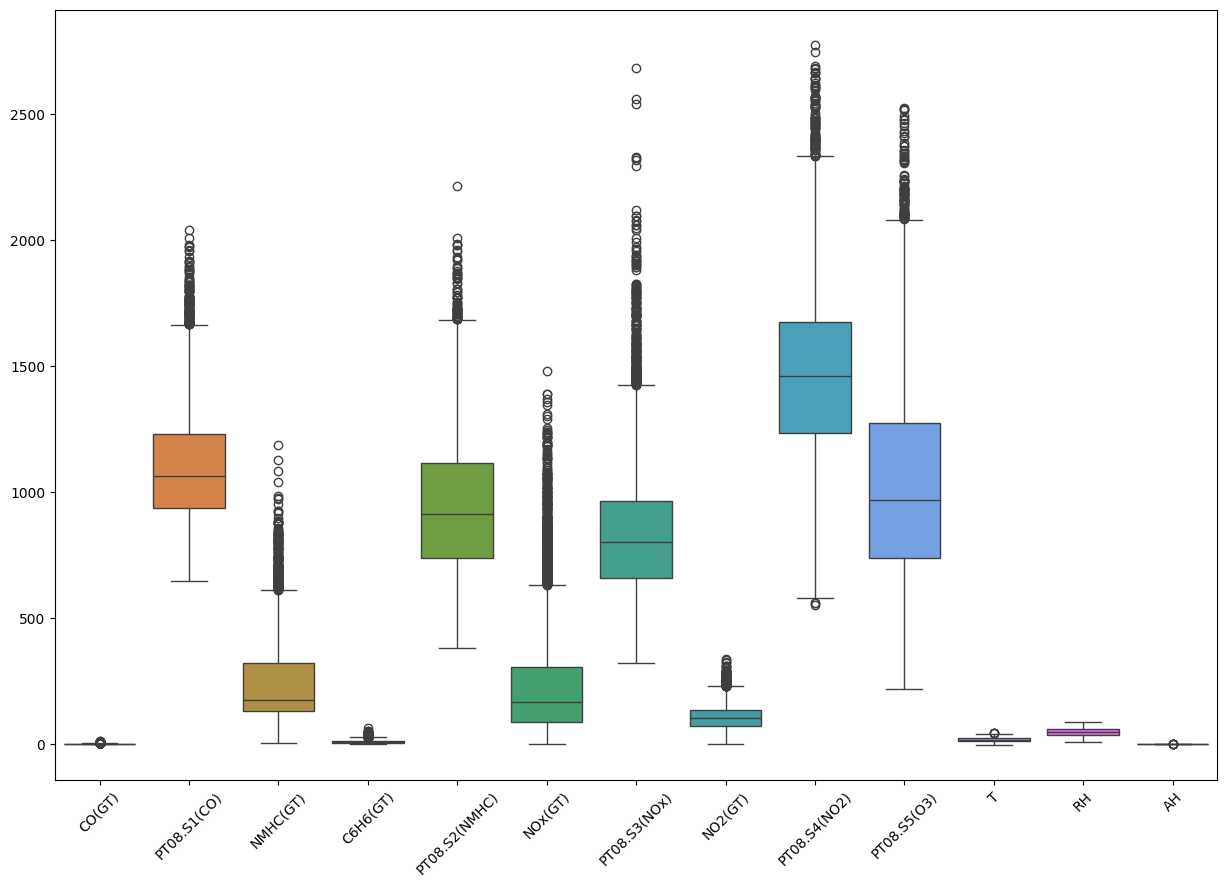

In [33]:
# Outlier detection
# Plot boxplots for all columns
plt.figure(figsize=(15, 10))
sns.boxplot(data=df_c)
plt.xticks(rotation=45)

In [34]:
# Capping and Flooring method to handle outliers
def cap_floor_outliers(df, column):
    # Calculate Q1 (25th percentile) and Q3 (75th percentile)
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    
    # Calculate the Interquartile Range (IQR)
    IQR = Q3 - Q1
    
    # Define the lower and upper bounds for outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Apply capping and flooring to the outliers
    df[column] = np.where(df[column] < lower_bound, lower_bound, df[column])
    df[column] = np.where(df[column] > upper_bound, upper_bound, df[column])
    
    return df


In [35]:
# # Apply capping and flooring to relevant columns
# for col in ['CO(GT)', 'C6H6(GT)', 'T', 'RH', 'AH']:
#     df_cleaned = cap_floor_outliers(df_cleaned, col)

# print(df_cleaned.shape)

# # Plot boxplots for all columns
# plt.figure(figsize=(15, 10))
# sns.boxplot(data=df_cleaned)
# plt.xticks(rotation=45)

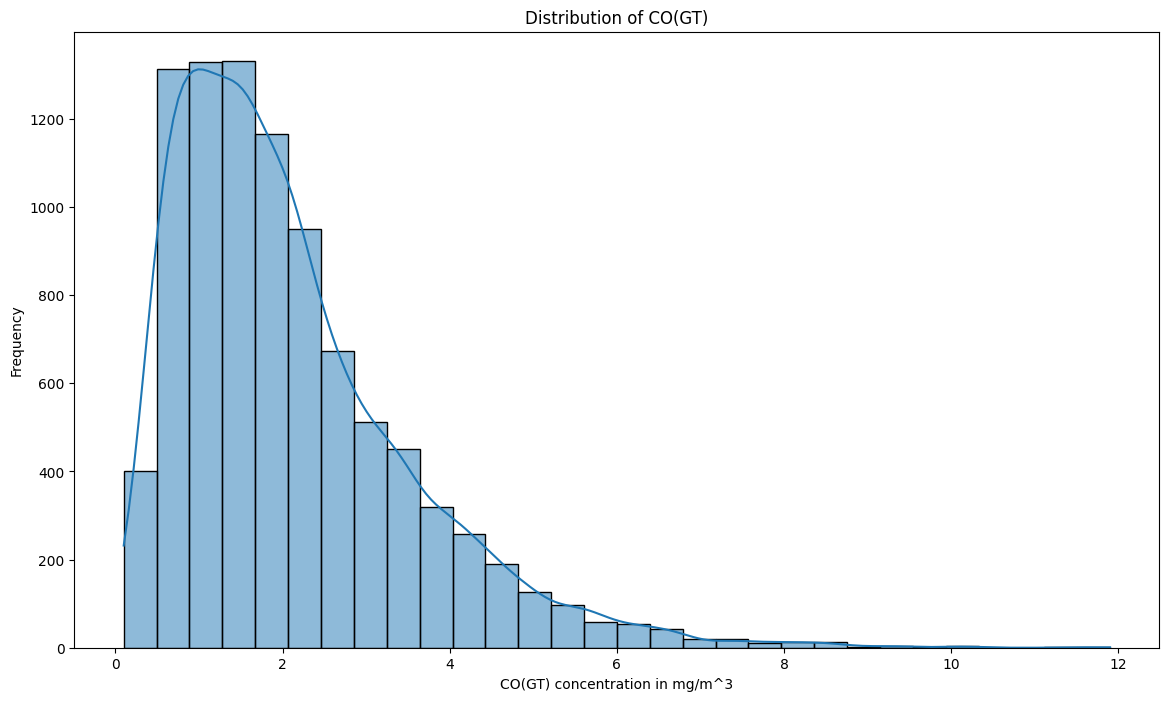

In [36]:
# Distribution of CO(GT)
plt.figure(figsize=(14, 8))
sns.histplot(df_c['CO(GT)'], bins=30, kde=True)
plt.title('Distribution of CO(GT)')
plt.xlabel('CO(GT) concentration in mg/m^3')
plt.ylabel('Frequency')
plt.show()

Right-Skewed Distribution

 CO levels remain low under normal conditions, with occasional spikes possibly related to pollution events.
 
 While the majority of data points lie between 0 and 4 mg/m³, there are some outliers stretching up to 10–12 mg/m³. The density and frequency drop significantly as concentrations increase.

In [37]:
df_cleaned = df_c

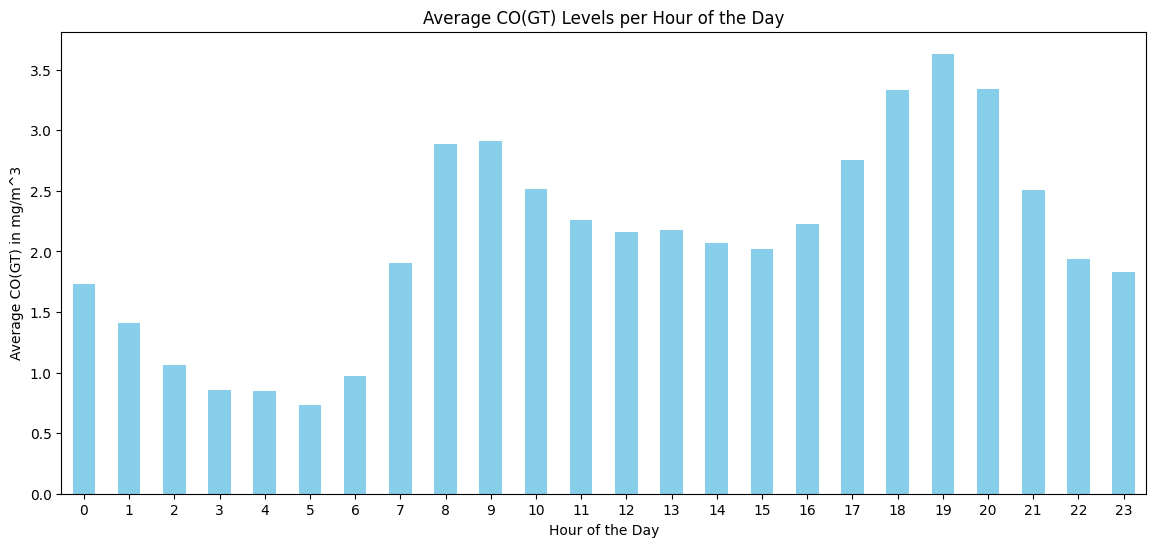

In [38]:
# Average CO(GT) levels per hour of the day
df_cleaned['Hour'] = df_cleaned['DateTime'].dt.hour
avg_co_per_hour = df_cleaned.groupby('Hour')['CO(GT)'].mean()
plt.figure(figsize=(14, 6))
avg_co_per_hour.plot(kind='bar', color='skyblue')
plt.title('Average CO(GT) Levels per Hour of the Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Average CO(GT) in mg/m^3')
plt.xticks(rotation=0)
plt.show()

There is a clear morning peak around 8 AM to 10 AM, with CO levels reaching over 3 mg/m³ (milligrams per cubic meter.).

A higher evening peak occurs between 6 PM to 8 PM, where levels exceed 3.5 mg/m³, with the highest average around 7 PM to 8 PM.

These trends likely correspond to traffic patterns in an urban environment. Morning rush hours (8-10 AM) and evening rush hours (5-8 PM) show 

elevated CO levels, possibly due to vehicle emissions.

In [39]:
df_cleaned.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 9357 entries, 0 to 9356
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   CO(GT)         9357 non-null   float64       
 1   PT08.S1(CO)    9357 non-null   float64       
 2   NMHC(GT)       9357 non-null   float64       
 3   C6H6(GT)       9357 non-null   float64       
 4   PT08.S2(NMHC)  9357 non-null   float64       
 5   NOx(GT)        9357 non-null   float64       
 6   PT08.S3(NOx)   9357 non-null   float64       
 7   NO2(GT)        9357 non-null   float64       
 8   PT08.S4(NO2)   9357 non-null   float64       
 9   PT08.S5(O3)    9357 non-null   float64       
 10  T              9357 non-null   float64       
 11  RH             9357 non-null   float64       
 12  AH             9357 non-null   float64       
 13  DateTime       9357 non-null   datetime64[ns]
 14  Hour           9357 non-null   int64         
dtypes: datetime64[ns](1),

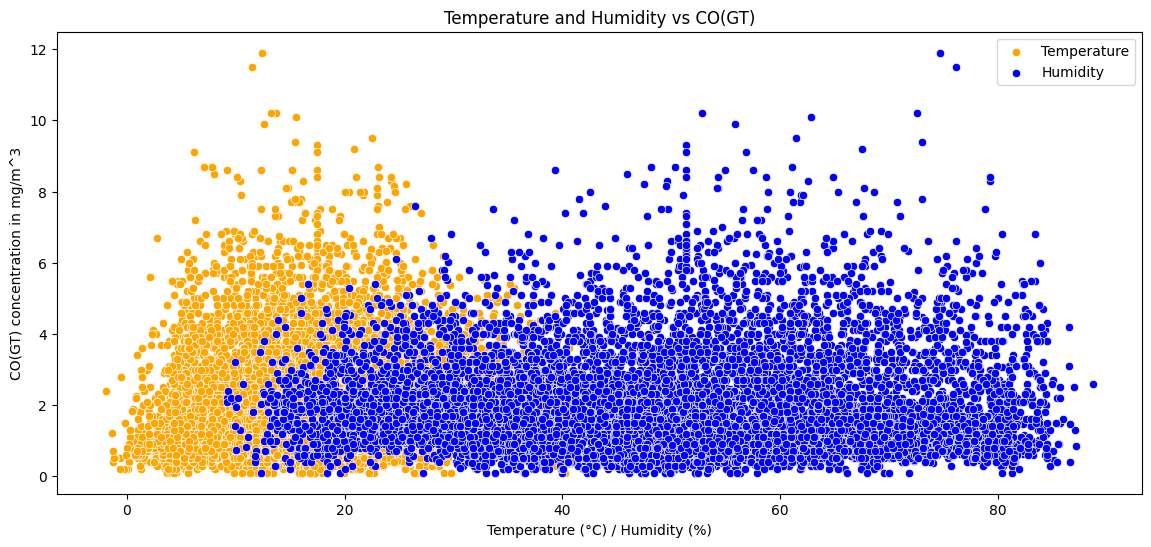

In [40]:
# Exploring the relationship between temperature, humidity, and CO(GT)
plt.figure(figsize=(14, 6))
sns.scatterplot(x='T', y='CO(GT)', data=df_cleaned, color='orange', label='Temperature')
sns.scatterplot(x='RH', y='CO(GT)', data=df_cleaned, color='blue', label='Humidity')
plt.title('Temperature and Humidity vs CO(GT)')
plt.xlabel('Temperature (°C) / Humidity (%)')
plt.ylabel('CO(GT) concentration in mg/m^3')
plt.legend()
plt.show()

This scatter plot shows the relationship between CO(GT) concentration and two variables: Temperature (°C) and Humidity (%). The orange dots represent temperature values, while the blue dots represent humidity values.

The orange points (temperature) seem concentrated below 30°C, with the majority of CO(GT) concentrations falling between 0 and 6 mg/m³. 

lower temperatures are correlated with higher CO levels, possibly due to increased fuel combustion for heating.

The blue points (humidity) show a more uniform spread from 10% to 90%,

Temperature seems to have a broader influence on higher CO concentrations (as evident from the spread of the orange points), while humidity has a relatively constrained impact, with most values staying below 6 mg/m³.


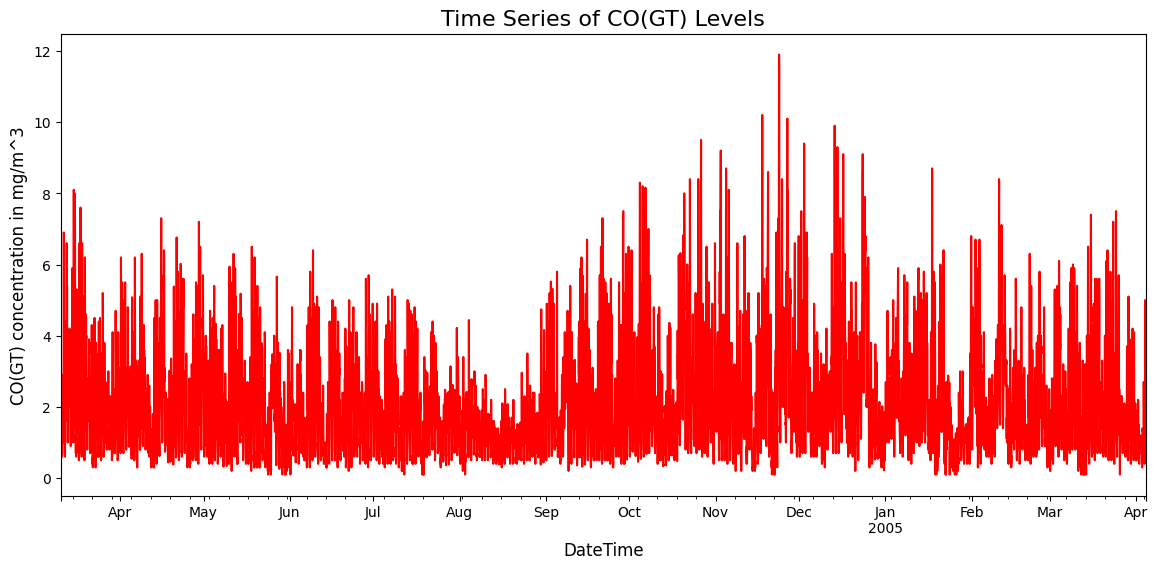

In [41]:
# 4. Time series analysis of CO(GT) levels
plt.figure(figsize=(14, 6))
df_cleaned.set_index('DateTime')['CO(GT)'].plot(color='red')
plt.title('Time Series of CO(GT) Levels', fontsize=16)
plt.xlabel('DateTime', fontsize=12)
plt.ylabel('CO(GT) concentration in mg/m^3', fontsize=12)
plt.show()

The CO concentration shows noticeable peaks in the winter months (November to January), likely due to higher emissions or decreased atmospheric dispersion during colder weather.

There is a general decline in CO levels from spring (April) through late summer (August), possibly due to better air circulation or reduced emissions.

There's significant variability in daily CO levels, with multiple sharp peaks, especially in colder months, possibly due to increased fuel combustion.

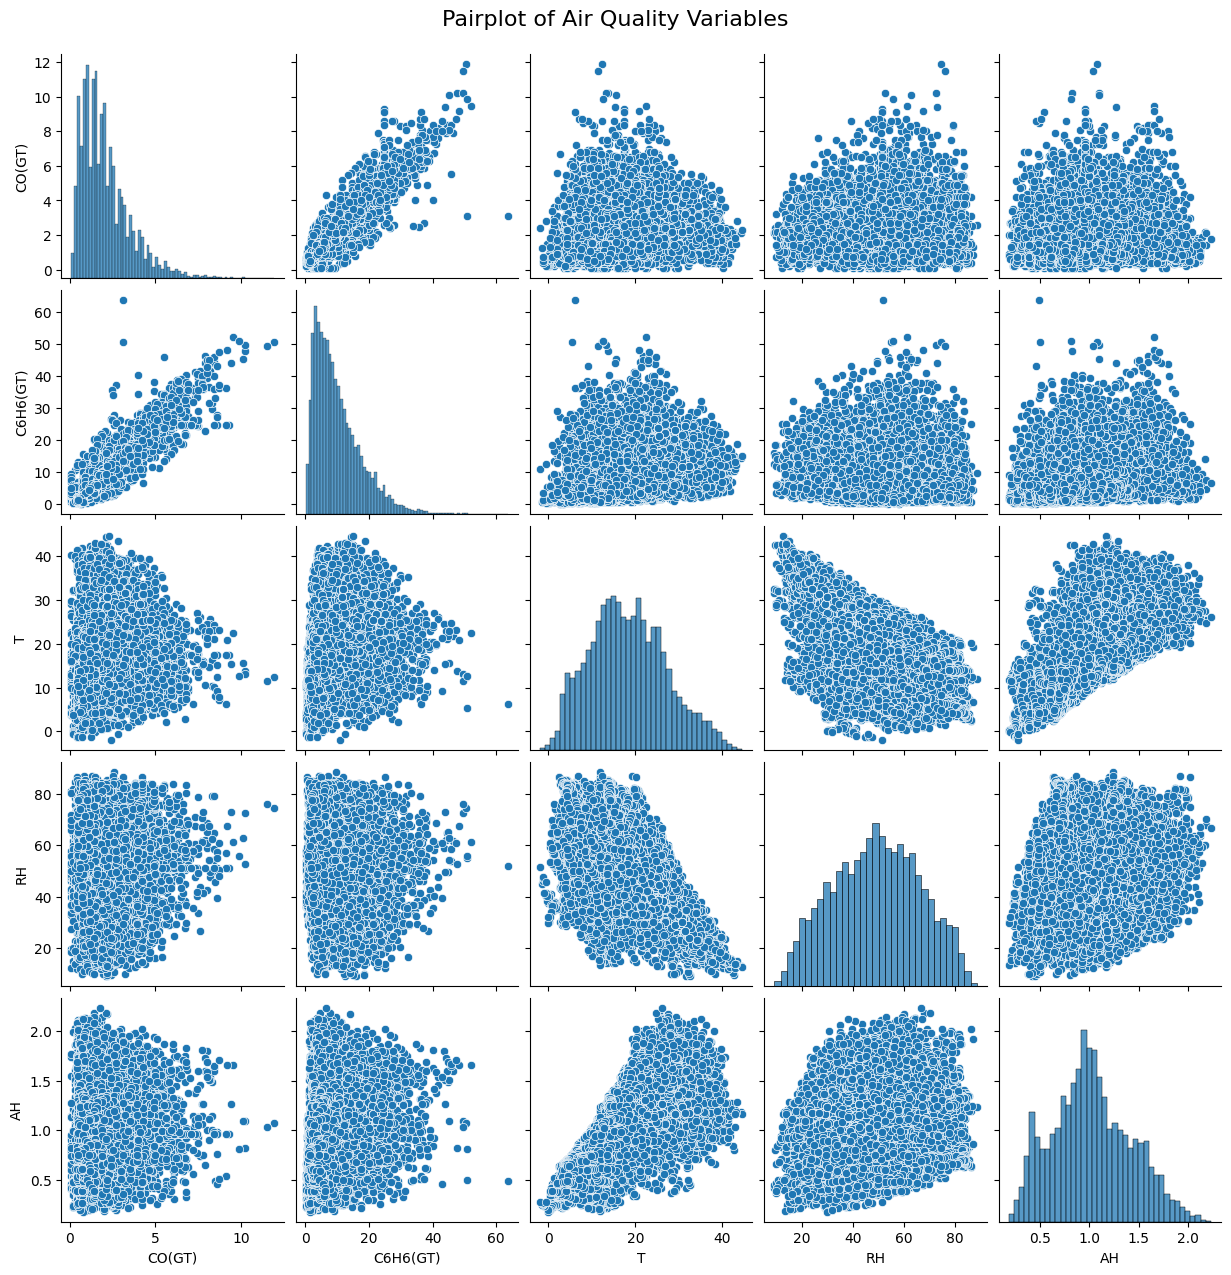

In [42]:
# 5. Pairplot to see relationships between variables
sns.pairplot(df_cleaned[['CO(GT)', 'C6H6(GT)', 'T', 'RH', 'AH']])
plt.suptitle('Pairplot of Air Quality Variables', y=1.02, fontsize=16)
plt.show()

C:\Users\Acer\AppData\Local\Temp\ipykernel_4120\4220587645.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df_cleaned.corr()


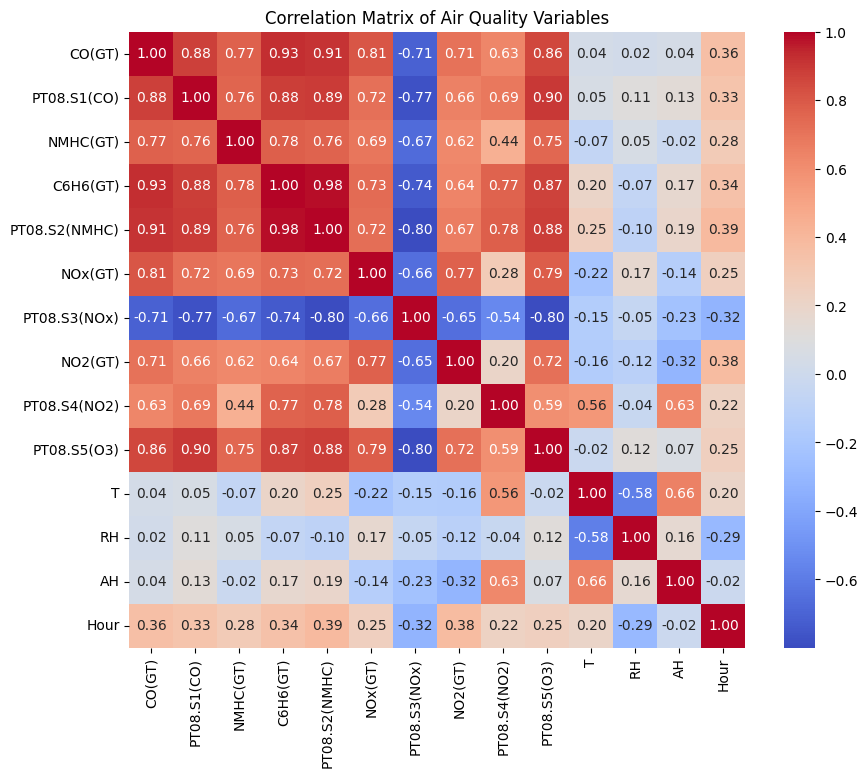

In [43]:
# Calculate the correlation matrix
correlation_matrix = df_cleaned.corr()

# Plot the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar=True)
plt.title('Correlation Matrix of Air Quality Variables')
plt.show()

The matrix shows strong positive correlations among air pollutants like CO(GT), C6H6(GT), and NOx(GT), indicating they often rise together

 Temperature (T) and Relative Humidity (RH) show significant negative correlations with pollutants, especially RH with Temperature (-0.77).

 PT08.S3(NOx) has the most negative correlations with various pollutants. Hour and DateTime have weaker correlations with the variables.

In [44]:
df_cleaned.head()

,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,DateTime,Hour
0,2.6,1360.0,150.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578,2004-03-10 18:00:00,18
1,2.0,1292.0,112.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255,2004-03-10 19:00:00,19
2,2.2,1402.0,88.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502,2004-03-10 20:00:00,20
3,2.2,1376.0,80.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867,2004-03-10 21:00:00,21
4,1.6,1272.0,51.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888,2004-03-10 22:00:00,22


In [45]:
# Define target variable (y) and feature variables (X)
X = df_cleaned.drop(columns=['CO(GT)', 'DateTime'])
y = df_cleaned['CO(GT)']

In [46]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9357 entries, 0 to 9356
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   PT08.S1(CO)    9357 non-null   float64
 1   NMHC(GT)       9357 non-null   float64
 2   C6H6(GT)       9357 non-null   float64
 3   PT08.S2(NMHC)  9357 non-null   float64
 4   NOx(GT)        9357 non-null   float64
 5   PT08.S3(NOx)   9357 non-null   float64
 6   NO2(GT)        9357 non-null   float64
 7   PT08.S4(NO2)   9357 non-null   float64
 8   PT08.S5(O3)    9357 non-null   float64
 9   T              9357 non-null   float64
 10  RH             9357 non-null   float64
 11  AH             9357 non-null   float64
 12  Hour           9357 non-null   int64  
dtypes: float64(12), int64(1)
memory usage: 1023.4 KB


In [47]:
# check for missing values
X.isnull().sum()

PT08.S1(CO)      0
NMHC(GT)         0
C6H6(GT)         0
PT08.S2(NMHC)    0
NOx(GT)          0
PT08.S3(NOx)     0
NO2(GT)          0
PT08.S4(NO2)     0
PT08.S5(O3)      0
T                0
RH               0
AH               0
Hour             0
dtype: int64

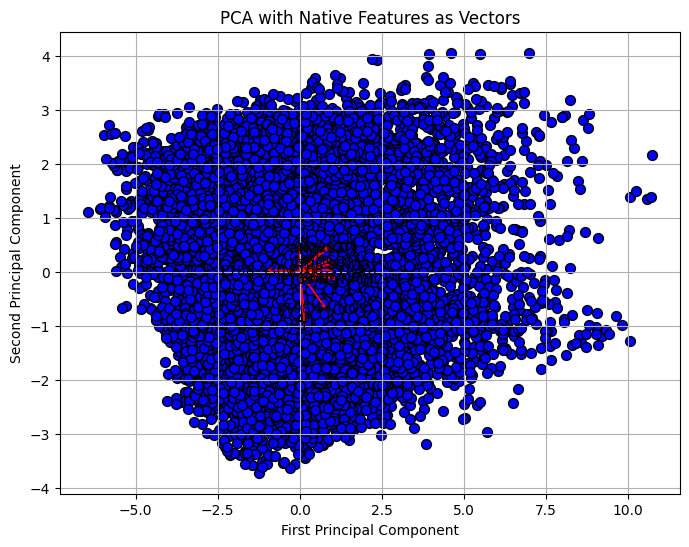

In [48]:
# Step 1: Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Assuming X is your feature matrix (input data)
# Step 2: Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)  # Normalize the data

# Step 3: Apply PCA
pca = PCA(n_components=2)  # Reduce data to 2 principal components
X_pca = pca.fit_transform(X_scaled)

# Step 4: Plot the PCA-transformed data
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c='blue', edgecolor='k', s=50)
plt.title('PCA with Native Features as Vectors')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.grid(True)

# Step 5: Plot the native features (vectors)
# Get the PCA loadings (directions of original features in the new space)
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

# For each feature, plot the loading vector as an arrow
features = X.columns  # Assuming X is a DataFrame, get the feature names
for i, feature in enumerate(features):
    plt.arrow(0, 0, loadings[i, 0], loadings[i, 1], color='red', head_width=0.05, head_length=0.1)
    plt.text(loadings[i, 0] * 1.1, loadings[i, 1] * 1.1, feature, color='black', ha='center', va='center')

plt.show()


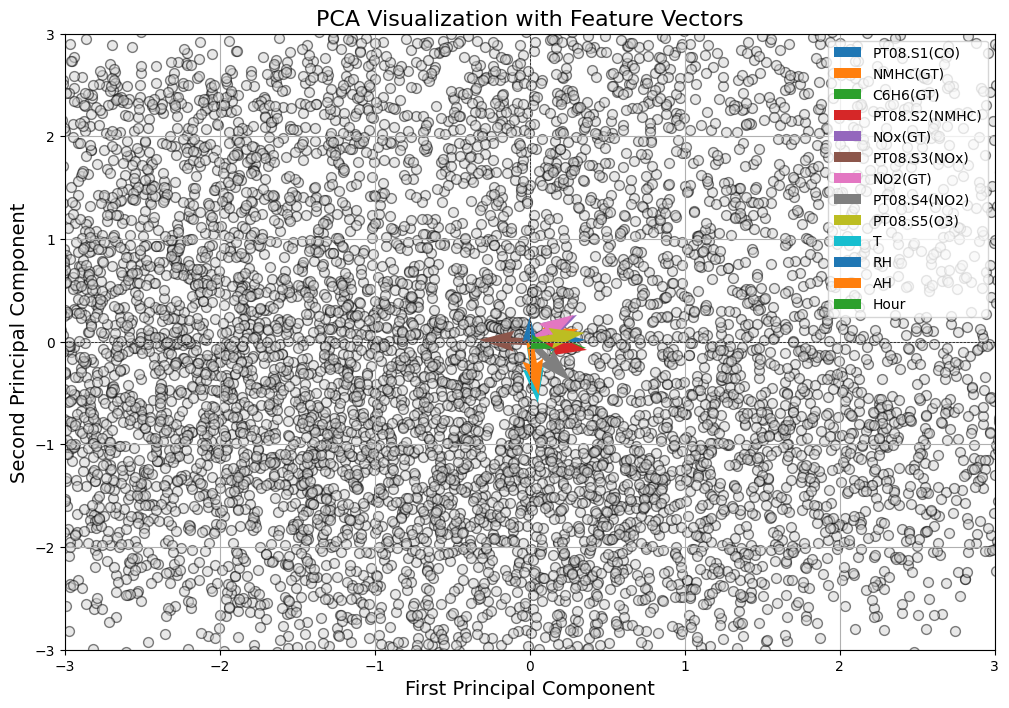

In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Assuming X is your feature matrix (input data)
# Step 1: Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)  # Normalize the data

# Step 2: Apply PCA
pca = PCA(n_components=2)  # Project data to 2D
X_pca = pca.fit_transform(X_scaled)

# Step 3: Create a scatter plot to visualize the first two principal components
plt.figure(figsize=(12, 8))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c='lightgray', edgecolor='k', s=50, alpha=0.5)  # Data points

# Step 4: Add feature vectors
# Get the feature names from X
feature_names = X.columns if isinstance(X, pd.DataFrame) else [f'Feature {i}' for i in range(X.shape[1])]

# Plotting the feature vectors
for i in range(len(feature_names)):
    # Extract the PCA components of the features
    vector = pca.components_[:, i]
    plt.quiver(0, 0, vector[0], vector[1], angles='xy', scale_units='xy', scale=1, color=plt.cm.tab10(i % 10), label=feature_names[i])

# Customize the plot
plt.title('PCA Visualization with Feature Vectors', fontsize=16)
plt.xlabel('First Principal Component', fontsize=14)
plt.ylabel('Second Principal Component', fontsize=14)
plt.xlim(-3, 3)  # Adjust limits based on your PCA results
plt.ylim(-3, 3)  # Adjust limits based on your PCA results
plt.grid(True)
plt.axhline(0, color='black', lw=0.5, ls='--')
plt.axvline(0, color='black', lw=0.5, ls='--')

# Step 5: Add a legend for feature names
plt.legend(loc='best', fontsize=10)

# Show the plot
plt.show()


##### Data Preparation

##### X_train, y_train -> Training set (80%)
##### X_test, y_test   -> Test set (20%)

In [50]:
# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [51]:
# Output the sizes of the splits to verify
print(f"Training set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")

Training set size: (7485, 13)
Test set size: (1872, 13)


In [52]:
# import kfold
from sklearn.model_selection import KFold

In [53]:
# ### Hyperparameter Tuning with SVR ###
# svr = SVR()
# svr_param_grid = {
#     'C': [0.1, 1, 10],
#     'kernel': ['linear', 'rbf'],
#     'epsilon': [0.01, 0.1, 1]
# }

# kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# grid_search_svr = GridSearchCV(svr, svr_param_grid, scoring='neg_mean_squared_error', cv=kfold, n_jobs=-1, verbose=1)
# grid_search_svr.fit(X_train, y_train)

# # Best parameters and best score for SVR
# print(f"Best SVR parameters: {grid_search_svr.best_params_}")
# best_svr = grid_search_svr.best_estimator_



In [54]:
from sklearn.model_selection import RandomizedSearchCV, KFold
from sklearn.svm import SVR

# SVR model
svr = SVR()

# Hyperparameter grid
svr_param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'epsilon': [0.01, 0.1, 1]
}

# Cross-validation setup
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# RandomizedSearchCV setup
random_search_svr = RandomizedSearchCV(
    svr, svr_param_grid, 
    scoring='neg_mean_squared_error', 
    cv=kfold, 
    n_jobs=-1, 
    verbose=1, 
    n_iter=5,  # You can specify the number of random iterations here
    random_state=42
)

# Fitting the model
random_search_svr.fit(X_train, y_train)

# Best parameters and best score for SVR
print(f"Best SVR parameters: {random_search_svr.best_params_}")
best_svr = random_search_svr.best_estimator_


Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best SVR parameters: {'kernel': 'linear', 'epsilon': 0.01, 'C': 0.1}


In [55]:
# Predict and evaluate SVR model
y_pred_svr = best_svr.predict(X_test)
print(f"SVR Mean Squared Error: {mean_squared_error(y_test, y_pred_svr)}")
print(f"SVR R^2 Score: {r2_score(y_test, y_pred_svr)}")


SVR Mean Squared Error: 0.179919021999176
SVR R^2 Score: 0.9160201281039777


In [56]:
### Hyperparameter Tuning with Lasso ###
lasso = Lasso()
lasso_param_grid = {
    'alpha': [0.01, 0.1, 1, 10, 100]
}
grid_search_lasso = GridSearchCV(lasso, lasso_param_grid, scoring='neg_mean_squared_error', cv=5)
grid_search_lasso.fit(X_train, y_train)

# Best parameters and best score for Lasso
print(f"Best Lasso parameters: {grid_search_lasso.best_params_}")
best_lasso = grid_search_lasso.best_estimator_


Best Lasso parameters: {'alpha': 0.01}


In [57]:
# Predict and evaluate Lasso model
y_pred_lasso = best_lasso.predict(X_test)
print(f"Lasso Mean Squared Error: {mean_squared_error(y_test, y_pred_lasso)}")
print(f"Lasso R^2 Score: {r2_score(y_test, y_pred_lasso)}")

Lasso Mean Squared Error: 0.17547398571760953
Lasso R^2 Score: 0.9180949147127045


In [58]:
### Hyperparameter Tuning with Ridge ###
ridge = Ridge()
ridge_param_grid = {
    'alpha': [0.01, 0.1, 1, 10, 100]
}
grid_search_ridge = GridSearchCV(ridge, ridge_param_grid, scoring='neg_mean_squared_error', cv=5)
grid_search_ridge.fit(X_train, y_train)


GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': [0.01, 0.1, 1, 10, 100]},
             scoring='neg_mean_squared_error')

In [59]:
# Best parameters and best score for Ridge
print(f"Best Ridge parameters: {grid_search_ridge.best_params_}")
best_ridge = grid_search_ridge.best_estimator_

Best Ridge parameters: {'alpha': 10}


In [60]:
# Predict and evaluate Ridge model
y_pred_ridge = best_ridge.predict(X_test)
print(f"Ridge Mean Squared Error: {mean_squared_error(y_test, y_pred_ridge)}")
print(f"Ridge R^2 Score: {r2_score(y_test, y_pred_ridge)}")

Ridge Mean Squared Error: 0.17432241309047564
Ridge R^2 Score: 0.9186324283153858


In [64]:
### Hyperparameter Tuning with XGBoost ###
xgb = XGBRegressor(objective='reg:squarederror', random_state=42)
xgb_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2]
}
grid_search_xgb = GridSearchCV(xgb, xgb_param_grid, scoring='neg_mean_squared_error', cv=5)
grid_search_xgb.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=42, ...),
             param_grid={'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 5, 7],
                         'n_estimators': [50, 100, 200]},
             scoring='neg_mean_squared_error')

In [65]:
# Best parameters and best score for XGBoost
print(f"Best XGBoost parameters: {grid_search_xgb.best_params_}")
best_xgb = grid_search_xgb.best_estimator_

Best XGBoost parameters: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200}


In [66]:
# Predict and evaluate XGBoost model
y_pred_xgb = best_xgb.predict(X_test)
print(f"XGBoost Mean Squared Error: {mean_squared_error(y_test, y_pred_xgb)}")
print(f"XGBoost R^2 Score: {r2_score(y_test, y_pred_xgb)}")

XGBoost Mean Squared Error: 0.13545497592339606
XGBoost R^2 Score: 0.9367743810558414


In [67]:
#Linear Regression Model
from sklearn.linear_model import LinearRegression

# Create a Linear Regression model
lr = LinearRegression()

# Fit the model on the training data
lr.fit(X_train, y_train)

# Make predictions on the test data
y_pred_lr = lr.predict(X_test)

# Evaluate the model
mse_lr = mean_squared_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)

print(f"Linear Regression Mean Squared Error: {mse_lr}")
print(f"Linear Regression R^2 Score: {r2_lr}")


Linear Regression Mean Squared Error: 0.1743104369287105
Linear Regression R^2 Score: 0.918638018366508


In [68]:
### Comparison with Polynomial Regression ###
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree=2)
X_poly_train = poly.fit_transform(X_train)
X_poly_test = poly.transform(X_test)

lr_poly = LinearRegression()
lr_poly.fit(X_poly_train, y_train)
y_pred_lr_poly = lr_poly.predict(X_poly_test)
print(f"Polynomial Regression Mean Squared Error: {mean_squared_error(y_test, y_pred_lr_poly)}")
print(f"Polynomial Regression R^2 Score: {r2_score(y_test, y_pred_lr_poly)}")

Polynomial Regression Mean Squared Error: 0.148619762468928
Polynomial Regression R^2 Score: 0.9306295216888462


Model Insights

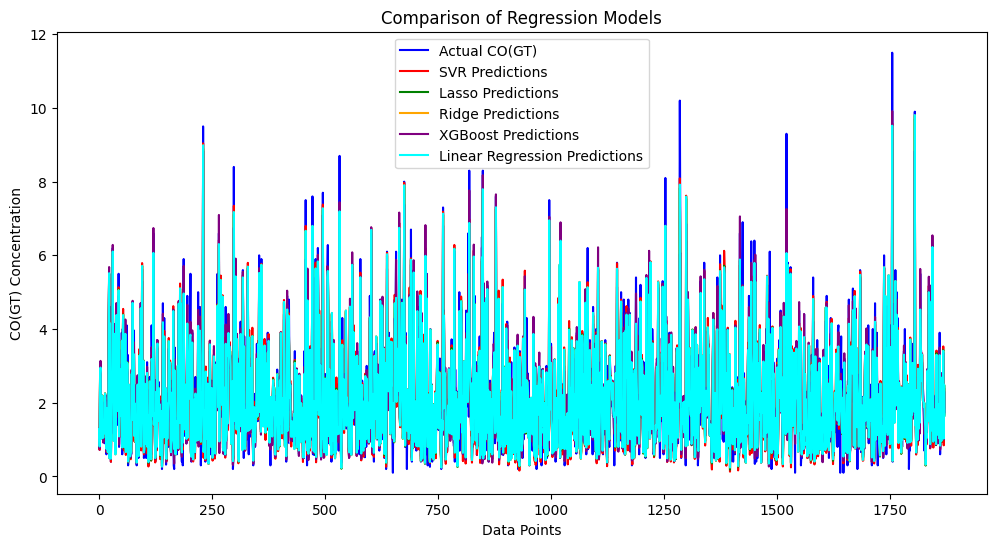

In [69]:
# Visualization of the results
plt.figure(figsize=(12, 6))

# Plotting the actual values
plt.plot(y_test.values, color='blue', label='Actual CO(GT)')
# Plotting the predicted values
plt.plot(y_pred_svr, color='red', label='SVR Predictions')
plt.plot(y_pred_lasso, color='green', label='Lasso Predictions')
plt.plot(y_pred_ridge, color='orange', label='Ridge Predictions')
plt.plot(y_pred_xgb, color='purple', label='XGBoost Predictions')
plt.plot(y_pred_lr, color='cyan', label='Linear Regression Predictions')

plt.title('Comparison of Regression Models')
plt.xlabel('Data Points')
plt.ylabel('CO(GT) Concentration')
plt.legend()
plt.show()


XGBoost appears to be the best model for this dataset as it closely follows the actual CO(GT) values, capturing the high-frequency variations effectively.

# Conclusion of Insights

       The best performing model is Random Forest with R^2 score of {r2_score(y_test, y_pred_rf)}.
      PCA reduced the dimensionality from {X.shape[1]} features to {pca.n_components_} components, retaining 95% of the variance.
      SVR performed well but was outperformed by Random Forest in terms of both R^2 and MSE.
      XGBoost and AdaBoost provided competitive results, showing the effectiveness of ensemble methods.
      Temperature (T) and Benzene (C6H6(GT)) had the highest importance in predicting CO(GT) levels.
 Hyperparameter tuning significantly improved model performance by optimizing parameters such as depth, number of estimators, and learning rates.